# Data Science Pipeline
Description : To create Data Science pipeline of UCI Credit Card Default
<br> Author : **Rizky Gagah Dewanda**
<br> Date   : 6 January 2021
* * *

In [1]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import sidetable as stb
import math
import datetime
from collections import Counter
from timeit import default_timer as timer
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.3f}".format
pd.options.display.max_columns = 50
pd.options.display.max_rows = 20

In [2]:
parameters = {
    "test_size": 0.3,
    "random_state": 42,
    "null_thres": 0.2,
    "corr_thres": 0.95,
    "contamination": 0.1,
    "numeric_pct": 40,
    "nominal_pct": 80,
    "over_mltp": 1,
}

In [25]:
# Feature engineering packages
from dask.distributed import Client, LocalCluster
import featuretools as ft

# Preprocessing packages
from category_encoders import CatBoostEncoder, JamesSteinEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import chi2, f_classif, SelectPercentile
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler

# Sampling packages
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline as PipelineImb

# Modelling packages
from sklearn.ensemble import (
    ExtraTreesClassifier,
    IsolationForest,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Calibarion packages
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Evaluation packages
from sklearn.metrics import (
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    plot_roc_curve,
    roc_auc_score,
)

import pickle
import joblib

In [4]:
def _get_time_delta(seconds=float) -> str:
    return str(datetime.timedelta(seconds=seconds))

def _downcast_numeric(x):
    if x.dtype == np.float64:
        return x.astype(np.float32)
    elif x.dtype == np.int64:
        return x.astype(np.int32)
    return x


def _create_client_entityset(
    clients: pd.DataFrame, profiles: pd.DataFrame, entity_id: str
) -> ft.EntitySet:
    es = ft.EntitySet(id=entity_id)
    es = es.entity_from_dataframe(
        entity_id="clients",
        dataframe=clients,
        index="ID",
        variable_types={
            "MARRIAGE": ft.variable_types.Categorical,
            "SEX": ft.variable_types.Categorical,
            "EDUCATION": ft.variable_types.Ordinal,
        },
    )
    es = es.entity_from_dataframe(
        entity_id="profiles",
        dataframe=profiles,
        index="PROFILE_ID",
        time_index="MONTH",
        make_index=True,
        variable_types={
            "ID": ft.variable_types.Id,
            "CREDIT_USE": ft.variable_types.Boolean,
        },
    )
    es = es.add_relationship(ft.Relationship(es["clients"]["ID"], es["profiles"]["ID"]))

    return es


def _initialize_dask_client(n_workers: int = 2, threads: Optional[int] = None) -> List:
    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=threads)

    return [Client(cluster), cluster]


def _get_column_dtype(df: pd.DataFrame) -> Dict:
    all_cols = df.columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    bool_cols = df.select_dtypes(include="boolean").columns.tolist()
    num_cols = df.select_dtypes(include="number").columns.tolist()

    # Add ID cols if it exists
    id_cols: List = []
    for col in ["ID"]:
        if col not in all_cols:
            continue
        if col in cat_cols:
            cat_cols.remove(col)
        if col in num_cols:
            num_cols.remove(col)
        id_cols.append(col)

    # Add default category cols if it exists but not detected as category
    for col in [
        "MARRIAGE",
        "SEX",
    ]:
        if col not in all_cols:
            continue
        if col in num_cols:
            num_cols.remove(col)
        if col not in cat_cols:
            cat_cols.append(col)
    cat_cols.sort()

    # Add default ordinal category if it exists
    ordi_cols: List = []
    for col in ["EDUCATION"]:
        if col not in all_cols:
            continue
        if col in cat_cols:
            cat_cols.remove(col)
        if col in num_cols:
            num_cols.remove(col)
        ordi_cols.append(col)
    ordi_cols.sort()

    # Add boolean cols if it exists but not detected as boolean
    for col in num_cols:
        if set(df[col].astype(float).unique()) == {0, 1}:
            bool_cols.append(col)
    bool_cols.sort()
    for col in bool_cols:
        if col in num_cols:
            num_cols.remove(col)
    num_cols.sort()

    # Seperate numerical columns with skewed distribution
    skew_check = pd.DataFrame(df[num_cols].skew(), columns=["skew"])

    num_skew_cols = skew_check[np.abs(skew_check["skew"]) >= 1].index.tolist()
    num_skew_cols.sort()
    for col in num_skew_cols:
        num_cols.remove(col)

    col_dict = {
        "id": id_cols,
        "num_normal": num_cols,
        "num_skewed": num_skew_cols,
        "ordinal": ordi_cols,
        "boolean": bool_cols,
        "category": cat_cols,
    }

    return col_dict


def _enforce_dtype(df: pd.DataFrame) -> pd.DataFrame:
    col_dict = _get_column_dtype(df)

    # Check if ID exists
    if col_dict["id"]:
        df[col_dict["id"]] = df[col_dict["id"]].astype("object")

    # Enforce dtype
    df[col_dict["num_normal"]] = df[col_dict["num_normal"]].apply(_downcast_numeric)
    df[col_dict["num_skewed"]] = df[col_dict["num_skewed"]].apply(_downcast_numeric)
    df[col_dict["boolean"]] = df[col_dict["boolean"]].astype(bool)
    df[col_dict["ordinal"]] = df[col_dict["ordinal"]].astype("category")
    df[col_dict["category"]] = df[col_dict["category"]].astype("category")

    return df


def _get_ct_feature_names(ct: ColumnTransformer) -> List:
    feature_names = []
    for name, trans, column in ct.transformers_:
        if trans == "drop" or (hasattr(column, "__len__") and not len(column)):
            continue
        if trans == "passthrough":
            feature_names.extend(column)
            continue
        # if hasattr(trans, "get_feature_names"):
        #     feature_names.extend(trans.get_feature_names(column))
        #     continue
        
        feature_names.extend(column)

    return feature_names


def _get_ct_support(ct: ColumnTransformer) -> List:
    support_list = []
    for name, trans, column in ct.transformers_:
        if not hasattr(trans, "get_support"):
            continue
        support_list.extend(trans.get_support())
    return support_list


def _inverse_ct_transform(df: pd.DataFrame, ct: ColumnTransformer) -> pd.DataFrame:
    df_inverse = df.copy()
    for name, trans, column in ct.transformers_:
        if trans == "drop" or (hasattr(column, "__len__") and not len(column)):
            continue
        if trans == "passthrough":
            continue
        if hasattr(trans, "inverse_transform"):
            df_inverse[column] = trans.inverse_transform(df_inverse[column])
            continue

    return df_inverse


def _get_oversample_strategy(series: pd.Series, multiplier: float = 1.0) -> Dict:
    if multiplier <= 0:
        raise ValueError("Multiplier must be within greater than 0.")
    
    counter = Counter(series)

    # Store the median sample of all labels
    median_sample = np.median([sample for label, sample in counter.items()])
    recommended_sample = math.ceil(median_sample * multiplier)

    sampling_strat: Dict = {}
    # Populate sampling stategy for oversampling
    for label, sample in counter.most_common():
        if sample <= median_sample:
            # Oversample label if its sample lower than median sample
            sampling_strat[label] = recommended_sample
            continue

        sampling_strat[label] = sample
        
    return sampling_strat

def _remove_unused_transformers(transformers: List) -> List:
    used_trans = transformers
    for i, trans_set in enumerate(used_trans):
        name, trans, column = trans_set
        if not column:
            used_trans.pop(i)

    return used_trans

def _remove_unused_steps(steps: List, remove_clf: bool = False) -> List:
    used_steps = steps
    for i, step_set in enumerate(used_steps):
        name, trans = step_set
        if not trans:
            used_steps.pop(i)
            continue
        if (name == "classifier") and remove_clf:
            used_steps.pop(i)
            continue

    return used_steps

In [5]:
joblib.load(r"../data/06_models/resampler.pickle")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_n_trans',
                                                  StandardScaler(),
                                                  ['LAST(profiles.PERCENTILE(PAY_AMT))',
                                                   'LIMIT_BAL',
                                                   'MAX(profiles.PERCENTILE(BILL_AMT))',
                                                   'MAX(profiles.PERCENTILE(PAY_AMT))',
                                                   'MEAN(profiles.PERCENTILE(PAY_AMT))',
                                                   'MIN(profiles.PERCENTILE(PAY_AMT))',
                                                   'PERCENTILE(LIMIT_BAL)',
                                                   'PERCENTILE(MEAN(profiles.PAY_AMT)...
                                                   'STD(profiles.BILL_AMT)',
                                                   'STD(profiles.PAY_STATUS)',
      

## 1. Load dataset

In [5]:
clients = pd.read_parquet(
    r"../data/03_primary/normalized_clients.parquet"
)

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         30000 non-null  object
 1   LIMIT_BAL  30000 non-null  int32 
 2   SEX        30000 non-null  int64 
 3   EDUCATION  30000 non-null  int64 
 4   MARRIAGE   30000 non-null  int64 
 5   AGE        30000 non-null  int32 
dtypes: int32(2), int64(3), object(1)
memory usage: 1.1+ MB


In [6]:
profiles = pd.read_parquet(
    r"../data/03_primary/profiles.parquet"
)

profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180000 entries, 0 to 179999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          180000 non-null  object        
 1   MONTH       180000 non-null  datetime64[ns]
 2   PAY_STATUS  180000 non-null  int64         
 3   BILL_AMT    180000 non-null  int32         
 4   PAY_AMT     180000 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(1)
memory usage: 6.9+ MB


In [7]:
labels = pd.read_csv(
    r"../data/03_primary/labels.csv",
    dtype= { "ID" : "object", "DEFAULT_PAY": np.float32 }
)

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           30000 non-null  object 
 1   DEFAULT_PAY  30000 non-null  float32
dtypes: float32(1), object(1)
memory usage: 351.7+ KB


## 2. Add profile features

In [8]:
profiles = pd.merge(profiles, clients[["ID", "LIMIT_BAL"]], how="left", on="ID")

# Determine the percentage threshold of used balance from the limit
profiles["LIMIT_THRES"] = profiles["BILL_AMT"] / profiles["LIMIT_BAL"]

# Determine if the client use credit card on that month
profiles["CREDIT_USE"] = np.where(
    (profiles["PAY_STATUS"] == 0)
    & (profiles["BILL_AMT"] == 0)
    & (profiles["PAY_AMT"] == 0),
    False,
    True,
)

profiles.drop(columns="LIMIT_BAL", inplace=True)

## 3. Split data

In [9]:
(
    clients_train,
    clients_test,
    labels_train,
    labels_test,
) = train_test_split(
    clients,
    labels,
    test_size=parameters["test_size"],
    random_state=parameters["random_state"],
    stratify=labels["DEFAULT_PAY"],
)

profiles_train = profiles[profiles["ID"].isin(labels_train["ID"])]
profiles_test = profiles[profiles["ID"].isin(labels_test["ID"])]

In [10]:
print(f"Training set: {clients_train.shape[0]} rows")
print(f"Test set: {clients_test.shape[0]} rows")

Training set: 21000 rows
Test set: 9000 rows


## 4. Create feature definitions

In [22]:
# Initialize dask client
dask_client, dask_cluster = _initialize_dask_client(n_workers=2)
dask_client

Client Scheduler: tcp://127.0.0.1:56144 Dashboard: http://127.0.0.1:56143/status,Cluster Workers: 2 Cores: 12 Memory: 34.22 GB


In [13]:
# Store client columns
client_cols = clients_train.drop(columns="ID").columns.tolist()

# Create the EntitySet
es_train = _create_client_entityset(
    clients_train,
    profiles_train,
    "client_train_set"
)

# Create seed features
retirement_age = ft.Feature(es_train["clients"]["AGE"]) >= 55

# Start DFS
features_train, feature_defs = ft.dfs(
    entityset=es_train,
    target_entity="clients",
    agg_primitives=[
        "all",
        "count",
        "last",
        "max",
        "mean",
        "median",
        "min",
        "num_true",
        "percent_true",
        "std",
        "skew",
        "sum",
        "trend",
    ],
    trans_primitives=["percentile"],
    seed_features=[retirement_age],
    max_depth=2,
    dask_kwargs={"cluster": dask_cluster},
    verbose=True
)

print(f"Original features from DFS: {len(feature_defs)}")

features_train, feature_defs = ft.selection.remove_highly_null_features(
    features_train,
    features=feature_defs,
    pct_null_threshold=parameters["null_thres"],
)
print(f"Features after removing highly null features: {len(feature_defs)}")

features_train, feature_defs = ft.selection.remove_single_value_features(
    features_train, features=feature_defs
)
print(f"Features after removing single value features: {len(feature_defs)}")

features_train, feature_defs = ft.selection.remove_highly_correlated_features(
    features_train,
    features=feature_defs,
    pct_corr_threshold=parameters["corr_thres"],
    features_to_keep=client_cols,
)
print(
    f"Final features after removing highly correlated features: {len(feature_defs)}"
)
dask_client.close()

Built 125 features
EntitySet scattered to 2 workers in 4 seconds
Elapsed: 05:14 | Progress: 100%|██████████
Original features from DFS: 125
Features after removing highly null features: 125
Features after removing single value features: 123
Final features after removing highly correlated features: 72


In [14]:
features_train = features_train.reindex(index=clients_train["ID"])
features_train.reset_index(inplace=True)
features_train.index = clients_train.index

# Enforce dtype
features_train = _enforce_dtype(features_train)

features_train.head()

,ID,LIMIT_BAL,AGE,MARRIAGE,SEX,EDUCATION,AGE >= 55,ALL(profiles.CREDIT_USE),LAST(profiles.BILL_AMT),LAST(profiles.CREDIT_USE),LAST(profiles.LIMIT_THRES),LAST(profiles.PAY_AMT),LAST(profiles.PAY_STATUS),LAST(profiles.PROFILE_ID),MAX(profiles.BILL_AMT),MAX(profiles.LIMIT_THRES),MAX(profiles.PAY_AMT),MAX(profiles.PAY_STATUS),MEAN(profiles.BILL_AMT),MEAN(profiles.LIMIT_THRES),MEAN(profiles.PAY_AMT),MEAN(profiles.PAY_STATUS),MEDIAN(profiles.PAY_AMT),MEDIAN(profiles.PAY_STATUS),MIN(profiles.BILL_AMT),...,MEAN(profiles.PERCENTILE(BILL_AMT)),MEAN(profiles.PERCENTILE(PAY_AMT)),MEDIAN(profiles.PERCENTILE(PAY_STATUS)),MIN(profiles.PERCENTILE(BILL_AMT)),MIN(profiles.PERCENTILE(LIMIT_THRES)),MIN(profiles.PERCENTILE(PAY_AMT)),SKEW(profiles.PERCENTILE(BILL_AMT)),SKEW(profiles.PERCENTILE(LIMIT_THRES)),SKEW(profiles.PERCENTILE(PAY_AMT)),STD(profiles.PERCENTILE(BILL_AMT)),STD(profiles.PERCENTILE(LIMIT_THRES)),STD(profiles.PERCENTILE(PAY_AMT)),STD(profiles.PERCENTILE(PAY_STATUS)),"TREND(profiles.PERCENTILE(BILL_AMT), MONTH)","TREND(profiles.PERCENTILE(LIMIT_THRES), MONTH)","TREND(profiles.PERCENTILE(PAY_AMT), MONTH)","TREND(profiles.PERCENTILE(PAY_STATUS), MONTH)",PERCENTILE(MEAN(profiles.PAY_AMT)),PERCENTILE(SKEW(profiles.PAY_STATUS)),PERCENTILE(STD(profiles.BILL_AMT)),PERCENTILE(STD(profiles.LIMIT_THRES)),PERCENTILE(STD(profiles.PAY_AMT)),"PERCENTILE(TREND(profiles.BILL_AMT, MONTH))","PERCENTILE(TREND(profiles.PAY_AMT, MONTH))","PERCENTILE(TREND(profiles.PAY_STATUS, MONTH))"
11018,11019,160000,32,2,2,2,False,True,156098,True,0.976,6000,0,7713,156731,0.980,6000,0,155590.672,0.972,5850.000,0.000,6000.000,0.000,153234,...,0.931,0.815,0.430,0.929,0.900,0.804,-1.492,-1.663,-1.047,0.001,0.010,0.007,0.000,0.000,0.000,0.000,0.000,0.759,0.405,0.200,0.159,0.091,0.458,0.427,0.443
1710,1711,100000,30,2,2,1,False,True,28383,True,0.284,5000,0,1186,52588,0.526,10000,2,43046.500,0.430,4963.667,0.333,3923.000,0.000,28383,...,0.679,0.632,0.430,0.588,0.518,0.102,-0.643,-0.658,-1.187,0.062,0.060,0.303,0.206,-0.001,-0.001,0.003,-0.001,0.713,0.919,0.674,0.696,0.753,0.042,0.898,0.058
4618,4619,80000,29,2,1,1,False,True,73722,True,0.922,3300,0,3233,75323,0.942,3300,0,57302.000,0.716,2026.000,0.000,1600.000,0.000,42231,...,0.734,0.520,0.430,0.670,0.658,0.458,0.080,0.243,1.287,0.065,0.106,0.093,0.000,0.001,0.002,0.001,0.000,0.445,0.405,0.770,0.821,0.294,0.853,0.673,0.443
5482,5483,20000,27,1,2,2,False,False,7286,True,0.364,1006,0,3834,7286,0.364,1006,0,1704.333,0.085,297.667,0.000,0.000,0.000,0,...,0.164,0.180,0.430,0.072,0.072,0.102,0.790,0.541,1.066,0.113,0.212,0.122,0.000,0.002,0.003,0.002,0.000,0.080,0.405,0.396,0.759,0.183,0.624,0.578,0.443
26187,26188,50000,30,2,2,1,False,False,0,True,0.000,2070,0,18378,2070,0.041,2070,0,345.000,0.007,345.000,0.000,0.000,0.000,0,...,0.100,0.178,0.430,0.072,0.072,0.102,2.449,2.449,2.449,0.069,0.104,0.186,0.000,0.000,0.001,0.002,0.000,0.089,0.405,0.141,0.277,0.343,0.492,0.655,0.443


## 5. Calculate features

In [24]:
# Create the EntitySet
es_test = _create_client_entityset(clients_test, profiles_test, "client_other_set")

# Calculate feature matrix
features_test = ft.calculate_feature_matrix(
    features=feature_defs,
    entityset=es_test,
    dask_kwargs={"cluster": dask_cluster},
    verbose=True,
)

dask_client.close()

# Reindex based on ID of clients
features_test = features_test.reindex(index=clients_test["ID"])
features_test.reset_index(inplace=True)

# Enforce dtype
features_test = _enforce_dtype(features_test)

# Make sure feature matrix have the same index as clients
features_test.index = clients_test.index

In [31]:
ft.save_features(feature_defs, r"../data/04_features/feature_definitions.json")

features_train.to_parquet(
    r"../data/04_features/features_train.parquet"
)
features_test.to_parquet(
    r"../data/04_features/features_test.parquet"
)
labels_train.to_csv(
    r"../data/04_features/labels_train.csv", index=False
)

labels_test.to_csv(
    r"../data/04_features/labels_test.csv", index=False
)

## 6. Train imputer

In [6]:
features_train = pd.read_parquet(
    r"../data/04_features/features_train.parquet"
)
features_test = pd.read_parquet(
    r"../data/04_features/features_test.parquet"
)

In [7]:
col_dict = _get_column_dtype(features_train)

transformers = [
    ("num_n_imputer", SimpleImputer(strategy="median"), col_dict["num_normal"]),
    ("num_s_imputer", SimpleImputer(strategy="median"), col_dict["num_skewed"]),
    (
        "ordi_imputer",
        SimpleImputer(strategy="constant", fill_value=0),
        col_dict["ordinal"],
    ),
    ("bool_pass", "passthrough", col_dict["boolean"]),
    (
        "cat_imputer",
        SimpleImputer(strategy="constant", fill_value=0),
        col_dict["category"],
    ),
]
transformers = _remove_unused_transformers(transformers)

# Combine the transformers as imputer
imputer = ColumnTransformer(transformers=transformers)
imputer.fit(features_train)

ColumnTransformer(transformers=[('num_n_imputer',
                                 SimpleImputer(strategy='median'),
                                 ['AGE', 'LAST(profiles.LIMIT_THRES)',
                                  'LAST(profiles.PERCENTILE(BILL_AMT))',
                                  'LAST(profiles.PERCENTILE(LIMIT_THRES))',
                                  'LAST(profiles.PERCENTILE(PAY_AMT))',
                                  'LAST(profiles.PROFILE_ID)', 'LIMIT_BAL',
                                  'MAX(profiles.PERCENTILE(BILL_AMT))',
                                  'MAX(profiles.PERCENTILE(LIMIT_THRES))'...
                                  'TREND(profiles.LIMIT_THRES, MONTH)',
                                  'TREND(profiles.PAY_AMT, MONTH)',
                                  'TREND(profiles.PERCENTILE(LIMIT_THRES), '
                                  'MONTH)']),
                                ('ordi_imputer',
                                 SimpleImputer(fill_va

In [8]:
input_cols = _get_ct_feature_names(imputer)
features_train_imp = pd.DataFrame(imputer.transform(features_train), columns=input_cols)

# Reindex based on ID of clients
features_train_imp.index = features_train["ID"]
features_train_imp = features_train_imp.reindex(index=features_train["ID"])
features_train_imp.reset_index(inplace=True)

# Enforce dtype
features_train = _enforce_dtype(features_train)

# Make sure feature matrix have the same index as clients
features_train_imp.index = features_train.index

features_train_imp

,ID,AGE,LAST(profiles.LIMIT_THRES),LAST(profiles.PERCENTILE(BILL_AMT)),LAST(profiles.PERCENTILE(LIMIT_THRES)),LAST(profiles.PERCENTILE(PAY_AMT)),LAST(profiles.PROFILE_ID),LIMIT_BAL,MAX(profiles.PERCENTILE(BILL_AMT)),MAX(profiles.PERCENTILE(LIMIT_THRES)),MAX(profiles.PERCENTILE(PAY_AMT)),MAX(profiles.PERCENTILE(PAY_STATUS)),MEAN(profiles.LIMIT_THRES),MEAN(profiles.PERCENTILE(BILL_AMT)),MEAN(profiles.PERCENTILE(PAY_AMT)),MIN(profiles.LIMIT_THRES),MIN(profiles.PERCENTILE(BILL_AMT)),MIN(profiles.PERCENTILE(LIMIT_THRES)),PERCENTILE(LIMIT_BAL),PERCENTILE(MEAN(profiles.PAY_AMT)),PERCENTILE(SKEW(profiles.PAY_STATUS)),PERCENTILE(STD(profiles.BILL_AMT)),PERCENTILE(STD(profiles.LIMIT_THRES)),PERCENTILE(STD(profiles.PAY_AMT)),"PERCENTILE(TREND(profiles.BILL_AMT, MONTH))",...,MEAN(profiles.PAY_STATUS),MEDIAN(profiles.PAY_AMT),MEDIAN(profiles.PAY_STATUS),MEDIAN(profiles.PERCENTILE(PAY_STATUS)),MIN(profiles.BILL_AMT),MIN(profiles.PAY_AMT),MIN(profiles.PAY_STATUS),MIN(profiles.PERCENTILE(PAY_AMT)),NUM_TRUE(profiles.CREDIT_USE),STD(profiles.BILL_AMT),STD(profiles.LIMIT_THRES),STD(profiles.PAY_STATUS),STD(profiles.PERCENTILE(BILL_AMT)),STD(profiles.PERCENTILE(LIMIT_THRES)),STD(profiles.PERCENTILE(PAY_STATUS)),"TREND(profiles.BILL_AMT, MONTH)","TREND(profiles.LIMIT_THRES, MONTH)","TREND(profiles.PAY_AMT, MONTH)","TREND(profiles.PERCENTILE(LIMIT_THRES), MONTH)",EDUCATION,AGE >= 55,ALL(profiles.CREDIT_USE),LAST(profiles.CREDIT_USE),MARRIAGE,SEX
11018,11019,32.000,0.976,0.931,0.922,0.820,7713.000,160000.000,0.932,0.928,0.820,0.430,0.972,0.931,0.815,0.958,0.929,0.900,0.557,0.759,0.405,0.200,0.159,0.091,0.458,...,0.000,6000.000,0.000,0.430,153234.000,5500.000,0.000,0.804,6.000,1236.513,0.008,0.000,0.001,0.010,0.000,1.991,0.000,1.962,0.000,2.000,0.000,1.000,1.000,2.000,2.000
1710,1711,30.000,0.284,0.588,0.518,0.771,1186.000,100000.000,0.735,0.657,0.899,0.934,0.430,0.679,0.632,0.284,0.588,0.518,0.398,0.713,0.919,0.674,0.696,0.753,0.042,...,0.333,3923.000,0.000,0.430,28383.000,0.000,0.000,0.102,6.000,10377.412,0.104,0.816,0.062,0.060,0.206,-171.257,-0.002,43.449,-0.001,1.000,0.000,1.000,1.000,2.000,2.000
4618,4619,29.000,0.922,0.800,0.869,0.677,3233.000,80000.000,0.804,0.885,0.677,0.430,0.716,0.734,0.520,0.528,0.670,0.658,0.334,0.445,0.405,0.770,0.821,0.294,0.853,...,0.000,1600.000,0.000,0.430,42231.000,1556.000,0.000,0.458,6.000,15624.992,0.195,0.000,0.065,0.106,0.000,254.518,0.003,10.448,0.002,1.000,0.000,1.000,1.000,2.000,1.000
5482,5483,27.000,0.364,0.342,0.563,0.365,3834.000,20000.000,0.342,0.563,0.365,0.430,0.085,0.164,0.180,0.000,0.072,0.072,0.050,0.080,0.405,0.396,0.759,0.183,0.624,...,0.000,0.000,0.000,0.430,0.000,0.000,0.000,0.102,3.000,2861.164,0.143,0.000,0.113,0.212,0.000,40.910,0.002,6.898,0.003,2.000,0.000,0.000,1.000,1.000,2.000
26187,26188,30.000,0.000,0.072,0.072,0.558,18378.000,50000.000,0.241,0.327,0.558,0.430,0.007,0.100,0.178,0.000,0.072,0.072,0.200,0.089,0.405,0.141,0.277,0.343,0.492,...,0.000,0.000,0.000,0.430,0.000,0.000,0.000,0.102,2.000,845.074,0.017,0.000,0.069,0.104,0.000,5.790,0.000,9.706,0.001,1.000,0.000,0.000,1.000,2.000,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,25781,32.000,0.054,0.396,0.348,0.102,18089.000,200000.000,0.396,0.348,0.102,0.430,0.009,0.126,0.102,0.000,0.072,0.072,0.654,0.024,0.405,0.490,0.332,0.027,0.644,...,0.000,0.000,0.000,0.430,0.000,0.000,0.000,0.102,1.000,4368.665,0.022,0.000,0.132,0.113,0.000,50.174,0.000,0.000,0.001,2.000,0.000,0.000,1.000,1.000,2.000
13921,13922,24.000,0.936,0.880,0.881,0.734,9769.000,120000.000,0.893,0.974,0.899,0.934,0.971,0.885,0.657,0.936,0.880,0.881,0.446,0.684,0.919,0.491,0.466,0.698,0.102,...,0.333,4150.000,0.000,0.430,112336.000,0.000,0.000,0.102,6.000,4386.914,0.037,0.816,0.006,0.043,0.206,-68.102,-0.001,12.769,-0.001,2.000,0.000,1.000,1.000,2.000,2.000
3794,3795,24.000,0.632,0.805,0.714,0.701,264

## 7. Impute missing values

In [9]:
# Remap imputer output to DataFrame
input_cols = _get_ct_feature_names(imputer)
features_test_imp = pd.DataFrame(imputer.transform(features_test), columns=input_cols)

# Reindex based on ID of clients
features_test_imp.index = features_test["ID"]
features_test_imp = features_test_imp.reindex(index=features_test["ID"])
features_test_imp.reset_index(inplace=True)

# Enforce dtype
features_test_imp = _enforce_dtype(features_test_imp)

# Make sure feature matrix have the same index as clients
features_test_imp.index = features_test.index

features_test_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 8941 to 20705
Data columns (total 73 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   ID                                              9000 non-null   object  
 1   AGE                                             9000 non-null   float32 
 2   LAST(profiles.LIMIT_THRES)                      9000 non-null   float32 
 3   LAST(profiles.PERCENTILE(BILL_AMT))             9000 non-null   float32 
 4   LAST(profiles.PERCENTILE(LIMIT_THRES))          9000 non-null   float32 
 5   LAST(profiles.PERCENTILE(PAY_AMT))              9000 non-null   float32 
 6   LAST(profiles.PROFILE_ID)                       9000 non-null   float32 
 7   LIMIT_BAL                                       9000 non-null   float32 
 8   MAX(profiles.PERCENTILE(BILL_AMT))              9000 non-null   float32 
 9   MAX(profiles.PERCENTILE(LI

In [10]:
joblib.dump(imputer, "../data/06_models/imputer_s.pickle") 

features_train_imp.to_parquet(
    r"../data/04_features/imputed_features_train.parquet"
)
features_test_imp.to_parquet(
    r"../data/04_features/imputed_features_test.parquet"
)

del features_train_imp, features_test_imp

## 7. Train outlier detectors

In [11]:
features_train = pd.read_parquet(
    r"../data/04_features/imputed_features_train.parquet"
)
features_test = pd.read_parquet(
    r"../data/04_features/imputed_features_test.parquet"
)

labels_train = pd.read_csv(
    r"../data/04_features/labels_train.csv", 
    dtype={ "ID": "object", "DEFAULT_PAY": float }
)

labels_test = pd.read_csv(
    r"../data/04_features/labels_test.csv", 
    dtype={ "ID": "object", "DEFAULT_PAY": float }
)

In [12]:
# Store columns by dtype
col_dict = _get_column_dtype(features_train)

if labels_train.shape[0] == features_train.shape[0]:
        labels_train.index = features_train.index

transformers=[
    ("num_n_trans", StandardScaler(), col_dict["num_normal"]),
    (
        "num_s_trans", 
        QuantileTransformer(
            random_state=parameters["random_state"]
        ), 
        col_dict["num_skewed"]
    ),
    ("ordi_trans", "passthrough", col_dict["ordinal"]),
    ("bool_pass", "passthrough", col_dict["boolean"]),
    (
        "cat_trans",
        CatBoostEncoder(
            return_df=False, random_state=parameters["random_state"]
        ),
        col_dict["category"],
    ),
]
transformers = _remove_unused_transformers(transformers)

# Combine the transformers as preprocessor
preprocessor = ColumnTransformer(transformers=transformers)

#  Extract target
target_train = labels_train["DEFAULT_PAY"]

# Train model to predict outliers
detector = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "detector", 
            IsolationForest(
                n_jobs=-1,
                contamination=parameters["contamination"],
                random_state=parameters["random_state"]
            )
        ),
    ]
)
detector.fit(features_train, target_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_n_trans',
                                                  StandardScaler(),
                                                  ['AGE',
                                                   'LAST(profiles.LIMIT_THRES)',
                                                   'LAST(profiles.PERCENTILE(BILL_AMT))',
                                                   'LAST(profiles.PERCENTILE(LIMIT_THRES))',
                                                   'LAST(profiles.PERCENTILE(PAY_AMT))',
                                                   'LAST(profiles.PROFILE_ID)',
                                                   'LIMIT_BAL',
                                                   'MAX(profiles.PERCENTILE(BILL_AMT))',
                                                   'MAX(profiles.PERCENTILE(...
                                                   'TREND(profiles.PERCENTILE(LIMIT_THRES), '
                

## 7. Remove outliers

In [13]:
print("Clients by default payment w/ outlier:")
labels_train.stb.freq(["DEFAULT_PAY"], style=True)

Clients by default payment w/ outlier:


,DEFAULT_PAY,count,percent,cumulative_count,cumulative_percent
0,0.000000,"16,355",77.88%,"16,355",77.88%
1,1.000000,"4,645",22.12%,"21,000",100.00%


In [14]:
# Log original rows
print("Original rows: {}".format(features_train.shape[0]))

# Store predicted outlier labels
features_train["OUTLIER"] = detector.predict(features_train)

features_train.stb.freq(["OUTLIER"], style=True)

# Remove outliers (outlier = -1)
features_train = features_train[features_train["OUTLIER"] != -1]
labels_train = labels_train[labels_train["ID"].isin(features_train["ID"])]
features_train.drop(columns="OUTLIER", inplace=True)

print("Final rows after removing outliers: {}.".format(features_train.shape[0]))

# Enforce dtype
features_train = _enforce_dtype(features_train)

Original rows: 21000
Final rows after removing outliers: 18900.


In [15]:
print("Clients by default payment w/o outlier:")
labels_train.stb.freq(["DEFAULT_PAY"], style=True)

Clients by default payment w/o outlier:


,DEFAULT_PAY,count,percent,cumulative_count,cumulative_percent
0,0.000000,"15,190",80.37%,"15,190",80.37%
1,1.000000,"3,710",19.63%,"18,900",100.00%


In [15]:
features_train.to_parquet(
    r"../data/04_features/inliner_features_train.parquet"
)

labels_train.to_csv(
    r"../data/04_features/inliner_labels_train.csv", index=False
)

## 8. Train feature selector

In [16]:
# Store columns by dtype
col_dict = _get_column_dtype(features_train)

if labels_train.shape[0] == features_train.shape[0]:
        labels_train.index = features_train.index

# Combine the transformers as column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num_n_trans", StandardScaler(), col_dict["num_normal"]),
        (
            "num_s_trans", 
            QuantileTransformer(
                random_state=parameters["random_state"]
            ), 
            col_dict["num_skewed"]
        ),
        ("ordi_trans", "passthrough", col_dict["ordinal"]),
        ("bool_pass", "passthrough", col_dict["boolean"]),
        (
            "cat_trans",
            JamesSteinEncoder(
                return_df=False, 
                random_state=parameters["random_state"]
            ),
            col_dict["category"],
        ),
    ],
)

num_cols = col_dict["num_normal"] + col_dict["num_skewed"]
nomi_cols = col_dict["ordinal"] + col_dict["boolean"] + col_dict["category"]

selector_ct = ColumnTransformer(
    transformers=[
        (
            "num_selector", 
            SelectPercentile(f_classif, percentile=parameters["numeric_pct"]), 
            [x for x in range(0, len(num_cols))]
        ),
        (
            "nomi_selector", 
            SelectPercentile(chi2, percentile=parameters["nominal_pct"]), 
            [x for x in range(len(num_cols), len(num_cols) + len(nomi_cols))]
        )
    ]
)

# Extract target
target_train = labels_train["DEFAULT_PAY"]

# Train feature selectior
selector = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("selector", selector_ct)
    ]
)
selector.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_n_trans',
                                                  StandardScaler(),
                                                  ['AGE',
                                                   'LAST(profiles.LIMIT_THRES)',
                                                   'LAST(profiles.PERCENTILE(BILL_AMT))',
                                                   'LAST(profiles.PERCENTILE(LIMIT_THRES))',
                                                   'LAST(profiles.PERCENTILE(PAY_AMT))',
                                                   'LAST(profiles.PROFILE_ID)',
                                                   'LIMIT_BAL',
                                                   'MAX(profiles.LIMIT_THRES)',
                                                   'MAX(profiles.PERCENTILE(BILL_AMT)...
                                                  JamesSteinEncoder(random_state=42,
                         

In [17]:
input_cols = _get_ct_feature_names(selector.named_steps["preprocessor"])
selected_cols = _get_ct_support(selector.named_steps["selector"])

features_train_sel = features_train[input_cols]
features_train_sel = features_train_sel.iloc[:, selected_cols]

features_train_sel.index = features_train["ID"]

# Reindex based on ID of clients
features_train_sel = features_train_sel.reindex(index=features_train["ID"])
features_train_sel.reset_index(inplace=True)

# Enforce dtype
features_train_sel = _enforce_dtype(features_train_sel)

# Make sure feature matrix have the same index as clients
features_train_sel.index = features_train.index

features_train_sel

,ID,LAST(profiles.PERCENTILE(PAY_AMT)),LIMIT_BAL,MEAN(profiles.PERCENTILE(PAY_AMT)),MIN(profiles.PERCENTILE(PAY_AMT)),PERCENTILE(LIMIT_BAL),PERCENTILE(MEAN(profiles.PAY_AMT)),PERCENTILE(STD(profiles.BILL_AMT)),"PERCENTILE(TREND(profiles.PAY_STATUS, MONTH))","TREND(profiles.PAY_STATUS, MONTH)","TREND(profiles.PERCENTILE(PAY_STATUS), MONTH)",LAST(profiles.PAY_AMT),LAST(profiles.PAY_STATUS),LAST(profiles.PERCENTILE(PAY_STATUS)),MAX(profiles.PAY_AMT),MAX(profiles.PAY_STATUS),MAX(profiles.PERCENTILE(PAY_STATUS)),MEAN(profiles.PAY_AMT),MEAN(profiles.PAY_STATUS),MEDIAN(profiles.PAY_AMT),MEDIAN(profiles.PAY_STATUS),MEDIAN(profiles.PERCENTILE(PAY_STATUS)),MIN(profiles.PAY_AMT),MIN(profiles.PAY_STATUS),STD(profiles.BILL_AMT),STD(profiles.PAY_STATUS),STD(profiles.PERCENTILE(PAY_STATUS)),EDUCATION,AGE >= 55,ALL(profiles.CREDIT_USE),LAST(profiles.CREDIT_USE)
11018,11019,0.820,160000.000,0.815,0.804,0.557,0.759,0.200,0.443,0.000,0.000,6000.000,0.000,0.430,6000.000,0.000,0.430,5850.000,0.000,6000.000,0.000,0.430,5500.000,0.000,1236.513,0.000,0.000,2.000,False,True,True
1710,1711,0.771,100000.000,0.632,0.102,0.398,0.713,0.674,0.058,-0.006,-0.001,5000.000,0.000,0.430,10000.000,2.000,0.934,4963.667,0.333,3923.000,0.000,0.430,0.000,0.000,10377.412,0.816,0.206,1.000,False,True,True
4618,4619,0.677,80000.000,0.520,0.458,0.334,0.445,0.770,0.443,0.000,0.000,3300.000,0.000,0.430,3300.000,0.000,0.430,2026.000,0.000,1600.000,0.000,0.430,1556.000,0.000,15624.992,0.000,0.000,1.000,False,True,True
5482,5483,0.365,20000.000,0.180,0.102,0.050,0.080,0.396,0.443,0.000,0.000,1006.000,0.000,0.430,1006.000,0.000,0.430,297.667,0.000,0.000,0.000,0.430,0.000,0.000,2861.164,0.000,0.000,2.000,False,False,True
26187,26188,0.558,50000.000,0.178,0.102,0.200,0.089,0.141,0.443,0.000,0.000,2070.000,0.000,0.430,2070.000,0.000,0.430,345.000,0.000,0.000,0.000,0.430,0.000,0.000,845.074,0.000,0.000,1.000,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,25781,0.102,200000.000,0.102,0.102,0.654,0.024,0.490,0.443,0.000,0.000,0.000,0.000,0.430,0.000,0.000,0.430,0.000,0.000,0.000,0.000,0.430,0.000,0.000,4368.665,0.000,0.000,2.000,False,False,True
13921,13922,0.734,120000.000,0.657,0.102,0.446,0.684,0.491,0.033,-0.009,-0.002,4200.000,0.000,0.430,10000.000,2.000,0.934,4493.333,0.333,4150.000,0.000,0.430,0.000,0.000,4386.914,0.816,0.206,2.000,False,True,True
3794,3795,0.701,120000.000,0.512,0.346,0.446,0.437,0.857,0.443,0.000,0.000,3700.000,0.000,0.430,3700.000,0.000,0.430,1989.833,0.000,2008.000,0.000,0.430,1000.000,0.000,23452.234,0.000,0.000,1.000,False,True,True
27565,27566,0.102,360000.000,0.159,0.102,0.904,0.065,0.075,0.852,0.005,0.002,0.000,1.000,0.871,860.000,1.000,0.871,184.333,0.167,0.000,0.000,0.430,0.000,0.000,355.804,0.408,0.180,1.000,True,True,True


In [18]:
features_train_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18900 entries, 11018 to 27126
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   ID                                             18900 non-null  object  
 1   LAST(profiles.PERCENTILE(PAY_AMT))             18900 non-null  float32 
 2   LIMIT_BAL                                      18900 non-null  float32 
 3   MEAN(profiles.PERCENTILE(PAY_AMT))             18900 non-null  float32 
 4   MIN(profiles.PERCENTILE(PAY_AMT))              18900 non-null  float32 
 5   PERCENTILE(LIMIT_BAL)                          18900 non-null  float32 
 6   PERCENTILE(MEAN(profiles.PAY_AMT))             18900 non-null  float32 
 7   PERCENTILE(STD(profiles.BILL_AMT))             18900 non-null  float32 
 8   PERCENTILE(TREND(profiles.PAY_STATUS, MONTH))  18900 non-null  float32 
 9   TREND(profiles.PAY_STATUS, MONTH)  

## 9. Select features

In [19]:
input_cols = _get_ct_feature_names(selector.named_steps["preprocessor"])
selected_cols = _get_ct_support(selector.named_steps["selector"])

features_test_sel = features_test[input_cols]
features_test_sel = features_test_sel.iloc[:, selected_cols]

features_test_sel.index = features_test["ID"]

# Reindex based on ID of clients
features_test_sel = features_test_sel.reindex(index=features_test["ID"])
features_test_sel.reset_index(inplace=True)

# Enforce dtype
features_test_sel = _enforce_dtype(features_test_sel)

# Make sure feature matrix have the same index as clients
features_test_sel.index = features_test.index

features_test_sel

,ID,LAST(profiles.PERCENTILE(PAY_AMT)),LIMIT_BAL,MEAN(profiles.PERCENTILE(PAY_AMT)),MIN(profiles.PERCENTILE(PAY_AMT)),PERCENTILE(LIMIT_BAL),PERCENTILE(MEAN(profiles.PAY_AMT)),PERCENTILE(STD(profiles.BILL_AMT)),"PERCENTILE(TREND(profiles.PAY_STATUS, MONTH))","TREND(profiles.PAY_STATUS, MONTH)","TREND(profiles.PERCENTILE(PAY_STATUS), MONTH)",LAST(profiles.PAY_AMT),LAST(profiles.PAY_STATUS),LAST(profiles.PERCENTILE(PAY_STATUS)),MAX(profiles.PAY_AMT),MAX(profiles.PAY_STATUS),MAX(profiles.PERCENTILE(PAY_STATUS)),MEAN(profiles.PAY_AMT),MEAN(profiles.PAY_STATUS),MEDIAN(profiles.PAY_AMT),MEDIAN(profiles.PAY_STATUS),MEDIAN(profiles.PERCENTILE(PAY_STATUS)),MIN(profiles.PAY_AMT),MIN(profiles.PAY_STATUS),STD(profiles.BILL_AMT),STD(profiles.PAY_STATUS),STD(profiles.PERCENTILE(PAY_STATUS)),EDUCATION,AGE >= 55,ALL(profiles.CREDIT_USE),LAST(profiles.CREDIT_USE)
8941,8942,0.777,230000.000,0.602,0.415,0.729,0.551,0.874,0.443,0.000,0.000,5000.000,0.000,0.431,5000.000,0.000,0.431,2804.833,0.000,2264.500,0.000,0.431,1300.000,0.000,25816.129,0.000,0.000,2.000,False,True,True
17618,17619,0.103,80000.000,0.213,0.103,0.335,0.174,0.155,0.927,0.010,0.002,0.000,0.000,0.431,4844.000,3.000,0.990,807.333,0.833,0.000,0.000,0.431,0.000,0.000,946.769,1.329,0.275,1.000,False,True,True
27895,27896,0.990,100000.000,0.712,0.507,0.402,0.933,0.943,0.443,0.000,0.000,70001.000,0.000,0.431,70001.000,0.000,0.431,16288.167,0.000,2888.500,0.000,0.431,1950.000,0.000,43279.285,0.000,0.000,1.000,False,True,True
16103,16104,0.103,10000.000,0.175,0.103,0.008,0.063,0.080,0.078,-0.003,-0.002,0.000,0.000,0.431,500.000,4.000,0.996,156.000,2.167,18.000,2.000,0.935,0.000,0.000,380.289,1.329,0.217,2.000,False,True,True
4422,4423,0.533,110000.000,0.539,0.103,0.430,0.552,0.524,0.443,0.000,0.000,2000.000,0.000,0.431,6400.000,0.000,0.431,2816.667,0.000,2000.000,0.000,0.431,0.000,0.000,5027.650,0.000,0.000,2.000,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27933,27934,0.840,180000.000,0.825,0.793,0.606,0.779,0.814,0.443,0.000,0.000,6500.000,0.000,0.431,7200.000,0.000,0.431,6036.333,0.000,5900.000,0.000,0.431,5018.000,0.000,18677.238,0.000,0.000,2.000,False,True,True
26623,26624,0.456,50000.000,0.403,0.349,0.199,0.289,0.145,0.443,0.000,0.000,1502.000,0.000,0.431,1522.000,0.000,0.431,1254.833,0.000,1251.000,0.000,0.431,1000.000,0.000,871.704,0.000,0.000,2.000,False,True,True
21750,21751,0.103,110000.000,0.445,0.103,0.430,0.388,0.334,0.443,0.000,0.000,0.000,0.000,0.431,3308.000,0.000,0.431,1675.833,0.000,1570.500,0.000,0.431,0.000,0.000,2160.868,0.000,0.000,2.000,False,True,True
14888,14889,0.103,450000.000,0.103,0.103,0.958,0.025,0.021,0.855,0.005,0.002,0.000,1.000,0.873,0.000,1.000,0.873,0.000,0.167,0.000,0.000,0.431,0.000,0.000,0.000,0.408,0.180,1.000,False,False,True


In [20]:
joblib.dump(selector, "../data/06_models/feature_selector_s.pickle") 

features_train_sel.to_parquet(
    r"../data/04_features/selected_features_train.parquet"
)
features_test_sel.to_parquet(
    r"../data/04_features/selected_features_test.parquet"
)

del features_train_sel

## 9. Find best resampler

In [21]:
features_train = pd.read_parquet(
    r"../data/04_features/selected_features_train.parquet"
)

labels_train = pd.read_csv(
    r"../data/04_features/inliner_labels_train.csv", dtype={ "ID": "object" }
)

In [22]:
labels_train.stb.freq(["DEFAULT_PAY"], style=True)

,DEFAULT_PAY,count,percent,cumulative_count,cumulative_percent
0,0.000000,"15,190",80.37%,"15,190",80.37%
1,1.000000,"3,710",19.63%,"18,900",100.00%


In [26]:
col_dict = _get_column_dtype(features_train)

if labels_train.shape[0] == features_train.shape[0]:
        labels_train.index = features_train.index

# Create transformers for each dtype
transformers = [
    ("num_n_trans", StandardScaler(), col_dict["num_normal"]),
    (
        "num_s_trans", 
        QuantileTransformer(
            random_state=parameters["random_state"]
        ), 
        col_dict["num_skewed"]
    ),
    ("ordi_trans", "passthrough", col_dict["ordinal"]),
    ("bool_pass", "passthrough", col_dict["boolean"]),
    (
        "cat_trans", 
        JamesSteinEncoder(
            return_df=False,
            random_state=parameters["random_state"]
        ), 
        col_dict["category"]
    ),
]
transformers = _remove_unused_transformers(transformers)

# Combine the transformers as preprocessor
preprocessor = ColumnTransformer(transformers=transformers)

num_cols = col_dict["num_normal"] + col_dict["num_skewed"]
nomi_cols = col_dict["ordinal"] + col_dict["boolean"] + col_dict["category"]

#  Extract target
target_train = labels_train["DEFAULT_PAY"]

# Initalize samplers
smotenc_smpl = SMOTENC(
    categorical_features=[
        x for x in range(len(num_cols), len(num_cols) + len(nomi_cols))
    ],
    n_jobs=-1,
    random_state=parameters["random_state"]
)
ro_smpl = RandomOverSampler(random_state=parameters["random_state"])
enn_smpl = EditedNearestNeighbours(n_jobs=-1)
tl_smpl = TomekLinks(n_jobs=-1)
ru_smpl = RandomUnderSampler(random_state=parameters["random_state"])

# Initalize classifier
clf = ExtraTreesClassifier(
    max_depth=10, 
    n_jobs=-1,
    random_state=parameters["random_state"]
)

# Create parameter grid
param_grid = {
    "sampler": [None, smotenc_smpl, ro_smpl, enn_smpl, tl_smpl, ru_smpl],
    "classifier": [clf],
}

# Create classifier pipeline
resampler = PipelineImb(
    steps=[
        ("preprocessor", preprocessor),
        ("sampler", smotenc_smpl),
        ("classifier", clf),
    ]
)

# Start grid search
search_cv = GridSearchCV(
    resampler,
    param_grid=param_grid,
    scoring=[
        "precision",
        "recall",
        "f1",
        "roc_auc",
    ],
    refit="f1",
    error_score=0,
    verbose=2
)

In [27]:
timer_start = timer()
search_cv.fit(features_train, target_train)
timer_end = timer()
print(f"Best resampler search elapsed time : {_get_time_delta(timer_end - timer_start)}.")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=None; total time=   2.8s
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=None; total time=   0.3s
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=None; total time=   0.4s
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=None; total time=   0.3s
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=None; total time=   0.3s
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=SMOTENC(categorical_features=[26, 27, 28, 29], random_state=42); total time=   1.6s
[CV] END classifier=ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42), sampler=SMOTENC(categorical_features=[26, 27, 28, 29], random_state=42); total time=   1.6s
[CV

In [28]:
search_results = pd.DataFrame(search_cv.cv_results_).sort_values(
    by=["rank_test_f1"]
)
resampler = search_cv.best_estimator_
search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_sampler,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
3,4.687,0.134,0.099,0.003,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...",EditedNearestNeighbours(n_jobs=-1),{'classifier': ExtraTreesClassifier(max_depth=...,0.497,0.497,0.481,0.463,0.521,0.492,0.019,3,0.512,0.539,0.454,0.465,0.501,0.494,0.031,4,0.505,0.517,0.467,0.464,0.511,0.493,0.023,1,0.773,0.781,0.740,0.728,0.772,0.759,0.021,3
1,1.614,0.031,0.098,0.004,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...","SMOTENC(categorical_features=[26, 27, 28, 29],...",{'classifier': ExtraTreesClassifier(max_depth=...,0.439,0.444,0.433,0.400,0.444,0.432,0.017,4,0.597,0.609,0.508,0.534,0.594,0.568,0.040,2,0.506,0.514,0.468,0.457,0.508,0.490,0.023,2,0.774,0.778,0.736,0.728,0.766,0.756,0.021,6
2,0.443,0.013,0.100,0.005,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...",RandomOverSampler(random_state=42),{'classifier': ExtraTreesClassifier(max_depth=...,0.435,0.448,0.430,0.400,0.439,0.431,0.016,5,0.589,0.597,0.495,0.538,0.597,0.563,0.041,3,0.501,0.512,0.460,0.459,0.506,0.488,0.023,3,0.773,0.781,0.735,0.727,0.771,0.757,0.022,4
5,0.230,0.013,0.097,0.004,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...",RandomUnderSampler(random_state=42),{'classifier': ExtraTreesClassifier(max_depth=...,0.413,0.419,0.408,0.384,0.415,0.408,0.012,6,0.625,0.643,0.544,0.570,0.608,0.598,0.036,1,0.498,0.507,0.467,0.459,0.493,0.485,0.019,4,0.775,0.779,0.738,0.725,0.770,0.757,0.022,5
4,4.815,0.026,0.102,0.003,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...",TomekLinks(n_jobs=-1),{'classifier': ExtraTreesClassifier(max_depth=...,0.658,0.655,0.617,0.591,0.644,0.633,0.026,2,0.319,0.367,0.298,0.321,0.350,0.331,0.024,5,0.430,0.470,0.402,0.416,0.454,0.434,0.025,5,0.775,0.783,0.738,0.729,0.772,0.759,0.021,2
0,0.827,0.963,0.101,0.009,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...",None,{'classifier': ExtraTreesClassifier(max_depth=...,0.688,0.699,0.663,0.645,0.675,0.674,0.019,1,0.298,0.329,0.268,0.276,0.307,0.296,0.022,6,0.416,0.447,0.382,0.387,0.422,0.411,0.024,6,0.775,0.783,0.739,0.728,0.772,0.759,0.022,1


In [29]:
resampler.set_params(
    steps=_remove_unused_steps(
            steps=resampler.steps,
            remove_clf=True
        )
)

resampler

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_n_trans',
                                                  StandardScaler(),
                                                  ['LAST(profiles.PERCENTILE(PAY_AMT))',
                                                   'LIMIT_BAL',
                                                   'MEAN(profiles.PERCENTILE(PAY_AMT))',
                                                   'MIN(profiles.PERCENTILE(PAY_AMT))',
                                                   'PERCENTILE(LIMIT_BAL)',
                                                   'PERCENTILE(MEAN(profiles.PAY_AMT))',
                                                   'PERCENTILE(STD(profiles.BILL_AMT))',
                                                   'PERCENTILE(TREND(profiles.PAY_ST...
                                                   'MEDIAN(profiles.PERCENTILE(PAY_STATUS))',
                                                   'MIN(profiles.PAY

In [30]:
joblib.dump(resampler, "../data/06_models/resampler_s.pickle") 

search_results.to_csv(
    r"../data/08_reporting/resampler_search_result.csv",
    index=False
)

## 10. Resample data

In [33]:
features_train_res = features_train
labels_train_res = labels_train

if "sampler" in resampler.named_steps:
    features_train_res, labels_train_res = resampler.fit_resample(features_train, target_train)

    # Remap resampler output to DataFrame
    input_cols = _get_ct_feature_names(resampler.named_steps["preprocessor"])

    features_train_res = pd.DataFrame(
        features_train_res,
        columns=input_cols
    )
    features_train_res = _inverse_ct_transform(
        df=features_train_res, 
        ct=resampler.named_steps["preprocessor"]
    )
    labels_train_res = pd.DataFrame(
        labels_train_res,
        columns=["DEFAULT_PAY"]
    )

    # Create fake ID from the index of resampled data
    features_train_res.index.name = "ID"
    labels_train_res.index.name = "ID"
    features_train_res.reset_index(inplace=True)
    labels_train_res.reset_index(inplace=True)

    # Enforce dtype
    features_train_res = _enforce_dtype(features_train_res)
    labels_train_res["ID"] = labels_train_res["ID"].astype("object")
    labels_train_res["DEFAULT_PAY"] = labels_train_res["DEFAULT_PAY"].astype(np.float32)

    # Make sure features have the same index as labels
    features_train_res.index = labels_train_res.index
    features_train_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13303 entries, 0 to 13302
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   ID                                             13303 non-null  object  
 1   LAST(profiles.PERCENTILE(PAY_AMT))             13303 non-null  float32 
 2   LIMIT_BAL                                      13303 non-null  float32 
 3   MEAN(profiles.PERCENTILE(PAY_AMT))             13303 non-null  float32 
 4   MIN(profiles.PERCENTILE(PAY_AMT))              13303 non-null  float32 
 5   PERCENTILE(LIMIT_BAL)                          13303 non-null  float32 
 6   PERCENTILE(MEAN(profiles.PAY_AMT))             13303 non-null  float32 
 7   PERCENTILE(STD(profiles.BILL_AMT))             13303 non-null  float32 
 8   PERCENTILE(TREND(profiles.PAY_STATUS, MONTH))  13303 non-null  float32 
 9   TREND(profiles.PAY_STATUS, MONTH)      

In [34]:
labels_train_res.stb.freq(["DEFAULT_PAY"], style=True)

,DEFAULT_PAY,count,percent,cumulative_count,cumulative_percent
0,0.000000,"9,593",72.11%,"9,593",72.11%
1,1.000000,"3,710",27.89%,"13,303",100.00%


In [35]:
features_train_res.to_parquet(
    r"../data/04_features/resampled_features_train.parquet"
)

labels_train_res.to_csv(
    r"../data/04_features/resampled_labels_train.csv", index=False
)

del features_train_res, labels_train_res

## 10. Train classifier

In [36]:
features_train = pd.read_parquet(
    r"../data/04_features/resampled_features_train.parquet"
)
features_test = pd.read_parquet(
    r"../data/04_features/selected_features_test.parquet"
)

labels_train = pd.read_csv(
    r"../data/04_features/resampled_labels_train.csv", dtype={ "ID": "object", "DEFAULT_PAY": float }
)

labels_test = pd.read_csv(
    r"../data/04_features/labels_test.csv", dtype={ "ID": "object", "DEFAULT_PAY": float }
)

In [37]:
labels_train.stb.freq(["DEFAULT_PAY"], style=True)

,DEFAULT_PAY,count,percent,cumulative_count,cumulative_percent
0,0.000000,"9,593",72.11%,"9,593",72.11%
1,1.000000,"3,710",27.89%,"13,303",100.00%


In [38]:
col_dict = _get_column_dtype(features_train)

if labels_train.shape[0] == features_train.shape[0]:
        labels_train.index = features_train.index

# Create transformers for each dtype
transformers = [
    ("num_n_trans", StandardScaler(), col_dict["num_normal"]),
    (
        "num_s_trans", 
        QuantileTransformer(
            random_state=parameters["random_state"]
        ), 
        col_dict["num_skewed"]
    ),
    ("ordi_trans", "passthrough", col_dict["ordinal"]),
    ("bool_pass", "passthrough", col_dict["boolean"]),
    (
        "cat_trans", 
        CatBoostEncoder(
            return_df=False, 
            random_state=parameters["random_state"]
        ), 
        col_dict["category"]
    ),
]
transformers = _remove_unused_transformers(transformers)

# Combine the transformers as preprocessor
preprocessor = ColumnTransformer(transformers=transformers)

num_cols = col_dict["num_normal"] + col_dict["num_skewed"]
nomi_cols = col_dict["ordinal"] + col_dict["boolean"] + col_dict["category"]

#  Extract target
target_train = labels_train["DEFAULT_PAY"]

# Initalize classifiers
gnb_clf = GaussianNB()
lr_clf = LogisticRegression(
    max_iter=200,
    random_state=parameters["random_state"],
    n_jobs=-1
)
knn_clf = KNeighborsClassifier(n_jobs=-1)
xt_clf = ExtraTreesClassifier(
    random_state=parameters["random_state"], 
    max_depth=10,
    n_jobs=-1
)
rf_clf = RandomForestClassifier(
    random_state=parameters["random_state"], 
    max_depth=10,
    n_jobs=-1
)
mlp_clf = MLPClassifier(
    max_iter=200,
    random_state=parameters["random_state"],
    early_stopping=True
)
lgbm_clf = LGBMClassifier(
    random_state=parameters["random_state"],
    max_depth=10,
    num_leaves=500,
    n_jobs=-1
)

# Create parameter grid
param_grid = {
    "classifier": [
        gnb_clf,
        lr_clf,
        knn_clf,
        xt_clf,
        rf_clf,
        mlp_clf,
        lgbm_clf,
    ],
}

# Create classifier pipeline
classifier = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", lr_clf)
    ]
)

# Start grid search
search_cv = GridSearchCV(
    classifier,
    param_grid=param_grid,
    scoring=[
        "precision",
        "recall",
        "f1",
        "roc_auc",
    ],
    refit="f1",
    error_score=0,
    verbose=2
)

In [39]:
timer_start = timer()
search_cv.fit(features_train, target_train)
timer_end = timer()
print(f"Best classifier search elapsed time : {_get_time_delta(timer_end - timer_start)}.")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ............................classifier=GaussianNB(); total time=   0.0s
[CV] END ............................classifier=GaussianNB(); total time=   0.0s
[CV] END ............................classifier=GaussianNB(); total time=   0.0s
[CV] END ............................classifier=GaussianNB(); total time=   0.0s
[CV] END ............................classifier=GaussianNB(); total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=200, n_jobs=-1, random_state=42); total time=   1.1s
[CV] END classifier=LogisticRegression(max_iter=200, n_jobs=-1, random_state=42); total time=   1.1s
[CV] END classifier=LogisticRegression(max_iter=200, n_jobs=-1, random_state=42); total time=   1.1s
[CV] END classifier=LogisticRegression(max_iter=200, n_jobs=-1, random_state=42); total time=   1.1s
[CV] END classifier=LogisticRegression(max_iter=200, n_jobs=-1, random_state=42); total time=   1.2s
[CV] END .........classifier=K

In [40]:
search_results = pd.DataFrame(search_cv.cv_results_).sort_values(by=["rank_test_f1"])
classifier = search_cv.best_estimator_
search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
2,0.036,0.003,1.361,0.022,KNeighborsClassifier(n_jobs=-1),{'classifier': KNeighborsClassifier(n_jobs=-1)},0.817,0.815,0.814,0.796,0.809,0.810,0.007,5,0.596,0.617,0.531,0.538,0.601,0.577,0.035,2,0.689,0.702,0.643,0.642,0.690,0.673,0.026,1,0.859,0.860,0.830,0.826,0.851,0.845,0.014,1
6,0.640,0.053,0.063,0.004,"LGBMClassifier(max_depth=10, num_leaves=500, r...","{'classifier': LGBMClassifier(max_depth=10, nu...",0.834,0.799,0.799,0.823,0.817,0.814,0.014,4,0.569,0.577,0.488,0.501,0.547,0.536,0.036,3,0.676,0.670,0.606,0.623,0.655,0.646,0.027,2,0.845,0.850,0.813,0.811,0.841,0.832,0.017,4
0,0.040,0.005,0.026,0.002,GaussianNB(),{'classifier': GaussianNB()},0.692,0.663,0.662,0.681,0.680,0.676,0.011,7,0.627,0.627,0.565,0.569,0.623,0.602,0.029,1,0.658,0.644,0.609,0.620,0.650,0.636,0.019,3,0.824,0.823,0.784,0.787,0.819,0.807,0.018,7
4,0.423,0.028,0.092,0.004,"RandomForestClassifier(max_depth=10, n_jobs=-1...",{'classifier': RandomForestClassifier(max_dept...,0.841,0.842,0.835,0.843,0.839,0.840,0.003,2,0.526,0.561,0.449,0.487,0.522,0.509,0.038,4,0.647,0.673,0.584,0.617,0.643,0.633,0.030,4,0.850,0.849,0.815,0.816,0.843,0.834,0.016,3
3,0.326,0.005,0.086,0.005,"ExtraTreesClassifier(max_depth=10, n_jobs=-1, ...",{'classifier': ExtraTreesClassifier(max_depth=...,0.852,0.843,0.826,0.849,0.868,0.847,0.014,1,0.527,0.550,0.447,0.476,0.512,0.502,0.037,5,0.651,0.666,0.580,0.610,0.644,0.630,0.031,5,0.846,0.852,0.815,0.815,0.847,0.835,0.016,2
5,1.666,0.728,0.037,0.003,"MLPClassifier(early_stopping=True, random_stat...",{'classifier': MLPClassifier(early_stopping=Tr...,0.800,0.798,0.804,0.844,0.846,0.818,0.022,3,0.543,0.547,0.447,0.445,0.504,0.497,0.044,7,0.647,0.649,0.575,0.583,0.632,0.617,0.032,6,0.836,0.843,0.806,0.804,0.843,0.827,0.018,5
1,1.207,0.024,0.030,0.004,"LogisticRegression(max_iter=200, n_jobs=-1, ra...",{'classifier': LogisticRegression(max_iter=200...,0.797,0.764,0.757,0.778,0.797,0.779,0.016,6,0.524,0.536,0.458,0.458,0.523,0.500,0.034,6,0.633,0.630,0.571,0.577,0.631,0.608,0.028,7,0.833,0.832,0.791,0.795,0.831,0.816,0.019,6


In [41]:
target_test = labels_test["DEFAULT_PAY"]

target_train_pred = classifier.predict(features_train)
target_test_pred = classifier.predict(features_test)

In [42]:
print(classification_report(target_train, target_train_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      9593
         1.0       0.92      0.67      0.77      3710

    accuracy                           0.89     13303
   macro avg       0.90      0.82      0.85     13303
weighted avg       0.89      0.89      0.89     13303



In [44]:
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81      7009
         1.0       0.42      0.60      0.49      1991

    accuracy                           0.72      9000
   macro avg       0.64      0.68      0.65      9000
weighted avg       0.77      0.72      0.74      9000



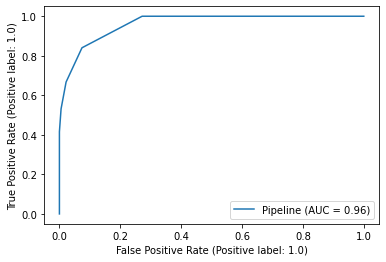

In [45]:
plot_roc_curve(classifier, features_train, target_train)

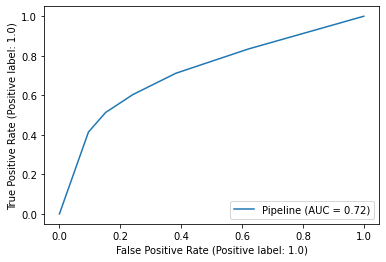

In [46]:
plot_roc_curve(classifier, features_test, target_test)

In [47]:
joblib.dump(classifier, "../data/06_models/classifier_s.pickle") 

search_results.to_csv(
    r"../data/08_reporting/classifier_search_result.parquet",
    index=False
)

## 11. Calibrate classifier

In [79]:
def plot_calibration_curve(est, est_name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    preprocessor = classifier.named_steps["preprocessor"]
    clf = classifier.named_steps["classifier"]

    # Calibrated with isotonic calibration
    isotonic = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier", 
                CalibratedClassifierCV(
                    clf,
                    method="isotonic"
                )
            )
        ]
    )

    # Calibrated with sigmoid calibration
    sigmoid = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier", 
                CalibratedClassifierCV(
                    clf,
                    method="sigmoid"
                )
            )
        ]
    )

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, est_name),
                      (isotonic, est_name + ' + Isotonic'),
                      (sigmoid, est_name + ' + Sigmoid')]:
        if name != est_name:
            clf.fit(features_train, target_train)
        target_pred = clf.predict(features_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(features_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(features_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(target_test, prob_pos, pos_label=target_test.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        # print("\tPrecision: %1.3f" % precision_score(target_test, target_pred))
        # print("\tRecall: %1.3f" % recall_score(target_test, target_pred))
        print("\tF1: %1.3f\n" % f1_score(target_test, target_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(target_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

    return [isotonic, sigmoid]

KNeighbors:
	Brier: 0.219
	F1: 0.492

KNeighbors + Isotonic:
	Brier: 0.194
	F1: 0.499

KNeighbors + Sigmoid:
	Brier: 0.197
	F1: 0.500



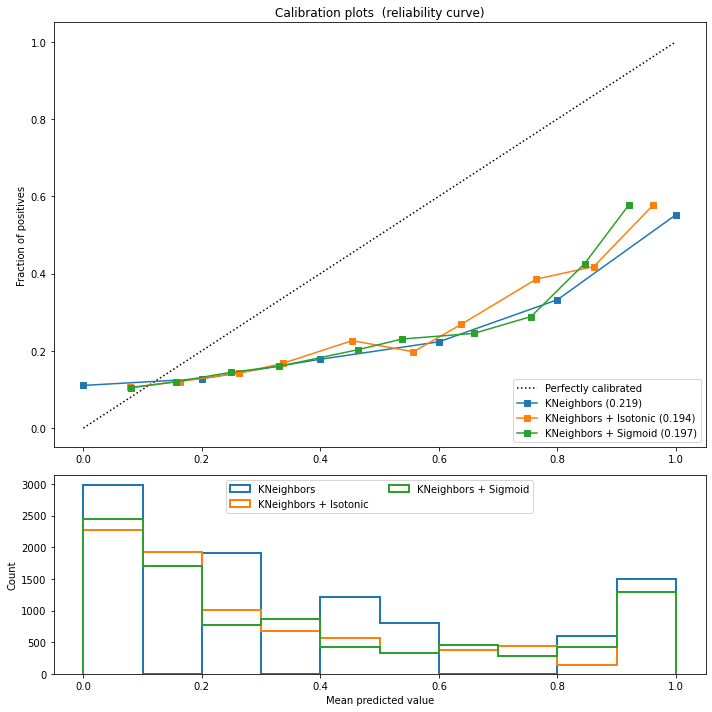

In [80]:
isotonic, sigmoid = plot_calibration_curve(classifier, "KNeighbors", 1)

In [81]:
target_train_pred_iso = isotonic.predict(features_train)
target_test_pred_iso = isotonic.predict(features_test)

target_train_pred_sig = sigmoid.predict(features_train)
target_test_pred_sig = sigmoid.predict(features_test)

In [82]:
print(classification_report(target_train, target_train_pred_iso))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92      9593
         1.0       0.93      0.60      0.73      3710

    accuracy                           0.88     13303
   macro avg       0.90      0.79      0.82     13303
weighted avg       0.88      0.88      0.87     13303



In [83]:
print(classification_report(target_test, target_test_pred_iso))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83      7009
         1.0       0.44      0.57      0.50      1991

    accuracy                           0.75      9000
   macro avg       0.66      0.68      0.66      9000
weighted avg       0.77      0.75      0.76      9000



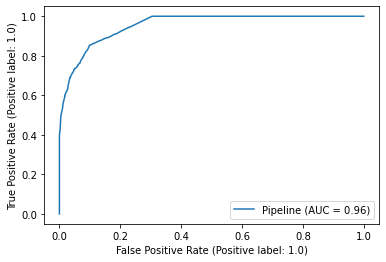

In [85]:
plot_roc_curve(isotonic, features_train, target_train)

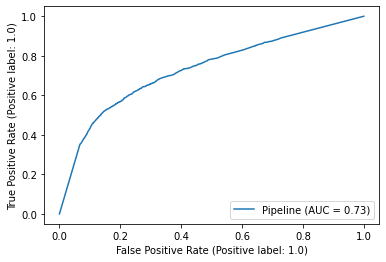

In [86]:
plot_roc_curve(isotonic, features_test, target_test)

In [87]:
print(classification_report(target_train, target_train_pred_sig))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      9593
         1.0       0.90      0.63      0.74      3710

    accuracy                           0.88     13303
   macro avg       0.89      0.80      0.83     13303
weighted avg       0.88      0.88      0.87     13303



In [88]:
print(classification_report(target_test, target_test_pred_sig))

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      7009
         1.0       0.43      0.60      0.50      1991

    accuracy                           0.73      9000
   macro avg       0.65      0.69      0.66      9000
weighted avg       0.77      0.73      0.75      9000



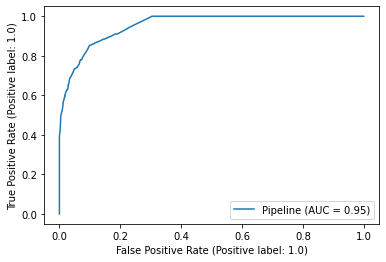

In [89]:
plot_roc_curve(sigmoid, features_train, target_train)

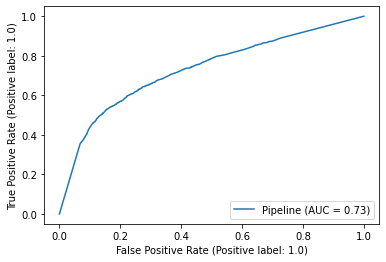

In [90]:
plot_roc_curve(sigmoid, features_test, target_test)

In [77]:
# Create parameter grid
param_grid = [
    { "classifier": [clf] },
    {
        "classifier": [CalibratedClassifierCV(clf)],
        "classifier__method": ["sigmoid", "isotonic"]
    }
]

# Start grid search
search_cv = GridSearchCV(
    classifier,
    param_grid=param_grid,
    scoring=[
        "precision",
        "recall",
        "f1",
        "roc_auc",
        "neg_brier_score"
    ],
    cv=2,
    refit="f1",
    error_score=0,
    verbose=2
)

In [74]:
search_results = pd.DataFrame(search_cv.cv_results_).sort_values(by=["rank_test_f1"])
classifier = search_cv.best_estimator_
search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__method,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_neg_brier_score,split1_test_neg_brier_score,split2_test_neg_brier_score,split3_test_neg_brier_score,split4_test_neg_brier_score,mean_test_neg_brier_score,std_test_neg_brier_score,rank_test_neg_brier_score
0,0.035,0.002,1.328,0.018,KNeighborsClassifier(n_jobs=-1),NaN,{'classifier': KNeighborsClassifier(n_jobs=-1)},0.817,0.815,0.814,0.796,0.809,0.810,0.007,3,0.596,0.617,0.531,0.538,0.601,0.577,0.035,1,0.689,0.702,0.643,0.642,0.690,0.673,0.026,1,0.859,0.860,0.830,0.826,0.851,0.845,0.014,3,-0.116,-0.113,-0.129,-0.131,-0.118,-0.121,0.007,3
1,2.073,0.015,5.043,0.080,CalibratedClassifierCV(base_estimator=KNeighbo...,sigmoid,{'classifier': CalibratedClassifierCV(base_est...,0.828,0.824,0.798,0.803,0.822,0.815,0.012,2,0.585,0.604,0.522,0.527,0.585,0.564,0.034,2,0.686,0.697,0.631,0.636,0.683,0.667,0.027,2,0.863,0.866,0.832,0.830,0.853,0.849,0.015,1,-0.115,-0.112,-0.127,-0.127,-0.115,-0.119,0.006,2
2,2.039,0.026,4.980,0.062,CalibratedClassifierCV(base_estimator=KNeighbo...,isotonic,{'classifier': CalibratedClassifierCV(base_est...,0.851,0.851,0.850,0.836,0.852,0.848,0.006,1,0.540,0.561,0.482,0.487,0.550,0.524,0.033,3,0.661,0.676,0.616,0.615,0.668,0.647,0.026,3,0.863,0.865,0.832,0.831,0.853,0.849,0.015,2,-0.115,-0.112,-0.127,-0.127,-0.115,-0.119,0.006,1


In [78]:
timer_start = timer()
search_cv.fit(features_train, target_train)
timer_end = timer()
print(f"Best calibration search elapsed time : {_get_time_delta(timer_end - timer_start)}.")

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .........classifier=KNeighborsClassifier(n_jobs=-1); total time=   2.2s
[CV] END .........classifier=KNeighborsClassifier(n_jobs=-1); total time=   2.1s
[CV] END classifier=CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_jobs=-1)), classifier__method=sigmoid; total time=   9.1s
[CV] END classifier=CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_jobs=-1)), classifier__method=sigmoid; total time=   8.9s
[CV] END classifier=CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_jobs=-1)), classifier__method=isotonic; total time=   9.1s
[CV] END classifier=CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_jobs=-1)), classifier__method=isotonic; total time=   9.0s
Best calibration search elapsed time : 0:00:40.971522.


## 10. Calibrate classifier

## 11. Evaluate Classifier